In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

### Load dataset info

In [3]:
path_to_train = '/kaggle/input/train/'
data = pd.read_csv('/kaggle/input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [4]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator

In [5]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [6]:
# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, (299,299,3), augument=True)

min: 0.0, max: 1.0


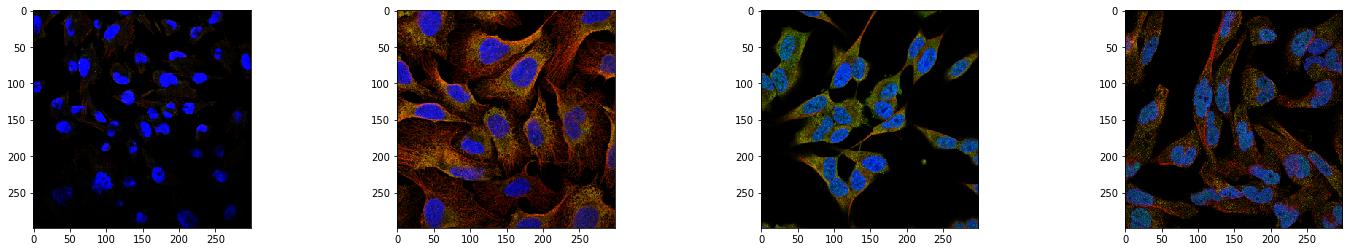

In [16]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,4,figsize=(25,4))
for i in range(4):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2, Xception
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

def create_model(input_shape, n_out):
    
    pretrain_model = Xception(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [12]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [13]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('accuracy')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

In [11]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

83689472/83683744 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       262272    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_1 (De

### Train model

In [15]:
checkpointer = ModelCheckpoint(
    '/kaggle/working/Xception.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

model.compile(
    loss='binary_crossentropy',  
    optimizer=Adam(1e-4),
    metrics=['acc', f1])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=180, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/180
100/100 [==============================] - 110s 1s/step - loss: 0.2463 - acc: 0.9145 - f1: 0.0504 - val_loss: 0.1914 - val_acc: 0.9386 - val_f1: 0.0425

Epoch 00001: val_loss improved from inf to 0.19138, saving model to /kaggle/working/Xception.model
Epoch 2/180
100/100 [==============================] - 95s 951ms/step - loss: 0.2031 - acc: 0.9375 - f1: 0.0500 - val_loss: 0.1857 - val_acc: 0.9389 - val_f1: 0.0424

Epoch 00002: val_loss improved from 0.19138 to 0.18566, saving model to /kaggle/working/Xception.model
Epoch 3/180
100/100 [==============================] - 95s 948ms/step - loss: 0.1946 - acc: 0.9386 - f1: 0.0499 - val_loss: 0.1834 - val_acc: 0.9408 - val_f1: 0.0466

Epoch 00003: val_loss improved from 0.18566 to 0.18337, saving model to /kaggle/working/Xception.model
Epoch 4/180
100/100 [==============================] - 95s 952ms/step - loss: 0.1884 - acc: 0.9408 - f1: 0.0507 - val_loss: 0.1822 - val_acc: 0.9424 - val_f1: 0.0445

Epoch 00004: val_loss improve


Epoch 00033: val_loss did not improve from 0.13785
Epoch 34/180
100/100 [==============================] - 95s 952ms/step - loss: 0.1362 - acc: 0.9539 - f1: 0.1076 - val_loss: 0.1423 - val_acc: 0.9540 - val_f1: 0.1066

Epoch 00034: val_loss did not improve from 0.13785
Epoch 35/180
100/100 [==============================] - 95s 951ms/step - loss: 0.1346 - acc: 0.9554 - f1: 0.1143 - val_loss: 0.1392 - val_acc: 0.9548 - val_f1: 0.1099

Epoch 00035: val_loss did not improve from 0.13785
Epoch 36/180
100/100 [==============================] - 95s 951ms/step - loss: 0.1375 - acc: 0.9527 - f1: 0.1099 - val_loss: 0.1376 - val_acc: 0.9541 - val_f1: 0.1081

Epoch 00036: val_loss improved from 0.13785 to 0.13756, saving model to /kaggle/working/Xception.model
Epoch 37/180
100/100 [==============================] - 95s 949ms/step - loss: 0.1325 - acc: 0.9553 - f1: 0.1190 - val_loss: 0.1336 - val_acc: 0.9563 - val_f1: 0.1183

Epoch 00037: val_loss improved from 0.13756 to 0.13359, saving model to


Epoch 00069: val_loss improved from 0.12208 to 0.11760, saving model to /kaggle/working/Xception.model
Epoch 70/180
100/100 [==============================] - 95s 952ms/step - loss: 0.1174 - acc: 0.9604 - f1: 0.1408 - val_loss: 0.1183 - val_acc: 0.9602 - val_f1: 0.1463

Epoch 00070: val_loss did not improve from 0.11760
Epoch 71/180
100/100 [==============================] - 95s 951ms/step - loss: 0.1162 - acc: 0.9603 - f1: 0.1434 - val_loss: 0.1199 - val_acc: 0.9590 - val_f1: 0.1453

Epoch 00071: val_loss did not improve from 0.11760
Epoch 72/180
100/100 [==============================] - 95s 950ms/step - loss: 0.1167 - acc: 0.9602 - f1: 0.1456 - val_loss: 0.1219 - val_acc: 0.9580 - val_f1: 0.1459

Epoch 00072: val_loss did not improve from 0.11760
Epoch 73/180
100/100 [==============================] - 95s 950ms/step - loss: 0.1116 - acc: 0.9617 - f1: 0.1449 - val_loss: 0.1161 - val_acc: 0.9612 - val_f1: 0.1520

Epoch 00073: val_loss improved from 0.11760 to 0.11605, saving model to


Epoch 00142: val_loss did not improve from 0.10559
Epoch 143/180
100/100 [==============================] - 95s 949ms/step - loss: 0.0960 - acc: 0.9677 - f1: 0.1656 - val_loss: 0.1254 - val_acc: 0.9618 - val_f1: 0.1577

Epoch 00143: val_loss did not improve from 0.10559
Epoch 144/180
100/100 [==============================] - 95s 950ms/step - loss: 0.0972 - acc: 0.9667 - f1: 0.1744 - val_loss: 0.1138 - val_acc: 0.9636 - val_f1: 0.1660

Epoch 00144: val_loss did not improve from 0.10559
Epoch 145/180
100/100 [==============================] - 95s 951ms/step - loss: 0.0934 - acc: 0.9686 - f1: 0.1759 - val_loss: 0.1177 - val_acc: 0.9621 - val_f1: 0.1687

Epoch 00145: val_loss did not improve from 0.10559
Epoch 146/180
100/100 [==============================] - 95s 951ms/step - loss: 0.0942 - acc: 0.9674 - f1: 0.1757 - val_loss: 0.1155 - val_acc: 0.9629 - val_f1: 0.1627

Epoch 00146: val_loss did not improve from 0.10559
Epoch 147/180
100/100 [==============================] - 95s 952ms/s

100/100 [==============================] - 95s 950ms/step - loss: 0.0905 - acc: 0.9693 - f1: 0.1856 - val_loss: 0.1060 - val_acc: 0.9647 - val_f1: 0.1744

Epoch 00180: val_loss did not improve from 0.10559


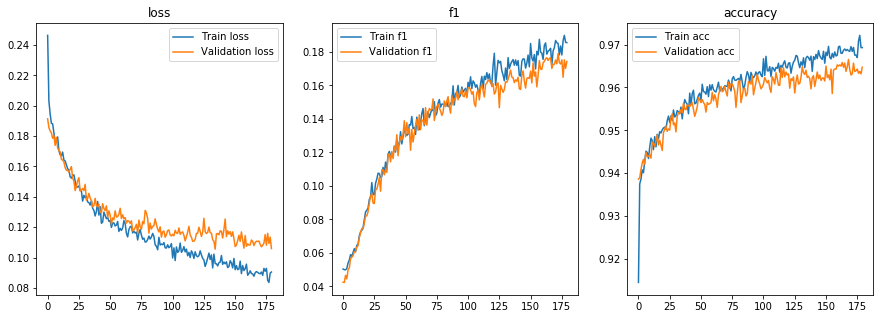

In [17]:
show_history(history)

### Create submit

In [18]:
model = load_model(
    '/kaggle/working/Xception.model', 
    custom_objects={'f1': f1})

In [19]:
submit = pd.read_csv('../input/sample_submission.csv')

In [20]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('../input/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [11:11<00:00, 17.42it/s]

CPU times: user 6min 4s, sys: 28.1 s, total: 6min 32s
Wall time: 11min 11s


In [23]:
submit['Predicted'] = predicted
submit.to_csv('submission.csv', index=False)